# MLOps Exercise: Medical Image Classification with Chest X-Ray Images

## Introduction

In this exercise, you'll gain practical experience with MLOps (Machine Learning Operations) by working on a real-world problem: classifying chest X-ray images to diagnose pneumonia. You'll go through various stages, from data cleaning to deployment, learning how to manage an end-to-end machine learning pipeline.

### Prerequisites

- Basic understanding of Python
- Familiarity with machine learning concepts
- Experience with Jupyter Notebooks

### Tools and Libraries

- Python
- NumPy
- OpenCV
- TensorFlow/Keras
- scikit-learn
- Flask
- Matplotlib
- imbalanced-learn

These libraries should cover most requirements for this exercise, including data manipulation (NumPy, pandas), visualization (Matplotlib), machine learning (scikit-learn, TensorFlow), image processing (OpenCV), and class imbalance treatment (imbalanced-learn).

### Table of Contents

1. [Data Loading and Cleaning](#Data-Loading-and-Cleaning)
2. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
3. [Class Imbalance](#Class-Imbalance)
4. [Model Building](#Model-Building)
5. [Data Augmentation](#Data-Augmentation)
6. [Model Evaluation](#Model-Evaluation)
7. [Model Deployment (Bonus)](#Model-Deployment-(Bonus))


## Environment Setup

Before we begin, let's set up the environment. We'll install the necessary Python packages for this exercise.

```bash
pip install numpy pandas opencv-python matplotlib scikit-learn tensorflow flask
```

You can also create a `requirements.txt` file with the above packages and install them using `pip install -r requirements.txt`.
Be aware that you should download ipykernel and export your env to the jupyter notebook.
```bash
python -m ipykernel install --user --name=my_new_env
```

## Data Loading and Cleaning

### Objective

Load the dataset and clean it by removing corrupted images.

### Guidance

1. Download the Chest X-Ray Images (Pneumonia) dataset and place it in a directory accessible by this notebook. From https://ametice.univ-amu.fr
2. Unzip the dataset and explore its directory structure.
3. Load the images and labels for training.
4. Write a function to scan for and remove any corrupted or invalid images.

### Exercise

Now, load the dataset use the zipfile library and clean it by removing corrupted images. Write your code in the cell below.

```python
import zipfile

zip_file_path = 'path/to/your/zip/file.zip'
extract_path = 'path/to/extract/folder'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
```

After extracting, your dataset should have the following folder structure:

```
/
|-- test/
|   |-- NORMAL/
|   |-- PNEUMONIA/
|-- train/
|   |-- NORMAL/
|   |-- PNEUMONIA/
|-- val/
    |-- NORMAL/
    |-- PNEUMONIA/
```

You can point `train_path` and `test_path` to the `train` and `test` folders inside this extracted directory

In [1]:
import zipfile

zip_file_path = '../data/Dataset.zip'
extract_path = '../data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [2]:
from PIL import Image
import os

data_dir = "../data/chest_xray"

def load_and_clean_data(data_dir):
    clean_data = []
    for folder in os.listdir(data_dir):
        if folder in ['train', 'test', 'val']:
            folder_path = os.path.join(data_dir, folder)
            for category in ['NORMAL', 'PNEUMONIA']:
                category_path = os.path.join(folder_path, category)
                for filename in os.listdir(category_path):
                    file_path = os.path.join(category_path, filename)
                    try:
                        # On ouvre l'image avec Pillow pour vérifier si elle est corrompue
                        img = Image.open(file_path)
                        # On ajoute le chemin du fichier à la liste des données propres
                        clean_data.append(file_path)
                    except Exception as e:
                        # Si une erreur se produit lors de l'ouverture de l'image, elle est corrompue
                        print(f"Image corrompue : {file_path} - {e}")
                        os.remove(e)
    return clean_data

# Chargement et nettoyage des données
clean_data = load_and_clean_data(data_dir)

print(f"Nombre total d'images propres : {len(clean_data)}")

Nombre total d'images propres : 5856


## Exploratory Data Analysis (EDA)

### Objective

Understand the dataset's basic statistics and visualize the data.

### Guidance

1. Use matplotlib to visualize some sample images from each class.
2. Investigate the distribution of classes (Pneumonia/Normal).

### Exercise

Perform exploratory data analysis on the dataset. Write your code in the cell below.


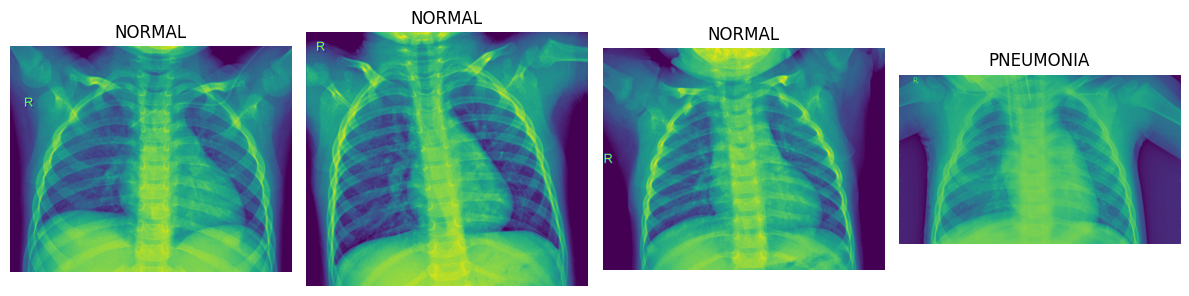

In [3]:
import matplotlib.pyplot as plt
import random

def visualize_samples(data_dir, clean_data):
    plt.figure(figsize=(12, 6))
    for i in range(4):  
        plt.subplot(2, 4, i + 1)
        category = random.choice(['NORMAL', 'PNEUMONIA'])
        category_path = os.path.join(data_dir, 'train', category)
        img_path = random.choice([img for img in os.listdir(category_path) if os.path.join(category_path, img) in clean_data])
        img = Image.open(os.path.join(category_path, img_path))
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(data_dir, clean_data)

Nombre d'images de 'PNEUMONIA' : 4273
Nombre d'images de 'NORMAL' : 1583


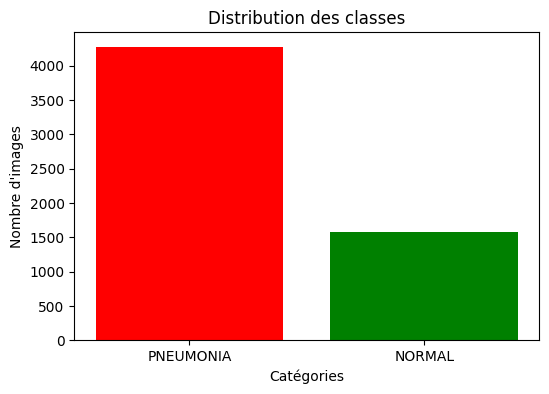

In [4]:
def analyze_class_distribution(clean_data):
    pneumonia_count = 0
    normal_count = 0
    for img_path in clean_data:
        if 'PNEUMONIA' in img_path:
            pneumonia_count += 1
        elif 'NORMAL' in img_path:
            normal_count += 1

    # Nombre d'images dans chaque classe
    print(f"Nombre d'images de 'PNEUMONIA' : {pneumonia_count}")
    print(f"Nombre d'images de 'NORMAL' : {normal_count}")

    # Visualisation de la distribution
    categories = ['PNEUMONIA', 'NORMAL']
    counts = [pneumonia_count, normal_count]
    plt.figure(figsize=(6, 4))
    plt.bar(categories, counts, color=['red', 'green'])
    plt.xlabel('Catégories')
    plt.ylabel('Nombre d\'images')
    plt.title('Distribution des classes')
    plt.show()

analyze_class_distribution(clean_data)

## Class Imbalance

### Objective

Understand how class imbalance affects model performance and learn ways to mitigate it.

### Guidance

1. Train a baseline model without accounting for class imbalance.
2. Evaluate its performance using metrics like accuracy, precision, recall, and F1-score.
3. Experiment with techniques like class weighting or oversampling methods like SMOTE to balance the classes.

### Exercise

Address the class imbalance and evaluate the impact on the model. Write your code in the cell below.


###### Avant nous devons normaliser les images pour qu'elle soit à la même taille, à la même couleurs  + division en ensembles d'entraînement et de test :
- Les images sont également étiquetées en fonction de leur nom de fichier, avec la classe 'NORMAL' représentée par 0 et la classe 'PNEUMONIA' représentée par 1.

In [5]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_preprocess_data(data_paths, target_size=(150, 150), test_size=0.2, random_state=42):
    images = []
    labels = []
    for img_path in data_paths:
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
            img = cv2.resize(img, target_size)  
            img_array = img / 255.0  # Normaliser les valeurs de pixels
            if img_array.shape == target_size:
                images.append(img_array)
                if 'NORMAL' in img_path:
                    labels.append(0)  # Classe NORMAL
                elif 'PNEUMONIA' in img_path:
                    labels.append(1)  # Classe PNEUMONIA
            else:
                print(f"Ignoring {img_path} due to inconsistent dimensions: {img_array.shape}")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    # Converti en tableaux numpy
    images = np.array(images)
    labels = np.array(labels)

    # Ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

Création d'un modèle de réseau de neurones avec trois couches suivies de couches de max-pooling pour extraire les caractéristiques des images

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Chargement des données train et test
X_train, X_test, y_train, y_test = load_and_preprocess_data(clean_data, target_size=(150, 150))

print("Dimensions de train :", X_train.shape, y_train.shape)
print("Dimensions de test :", X_test.shape, y_test.shape)

# Modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Utilisation de sigmoid car c'est un problème de classification binaire
])

# Compilation
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()

# Entrainement 
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Dimensions de train : (4684, 150, 150) (4684,)
Dimensions de test : (1172, 150, 150) (1172,)


Epoch 1/10
147/147 [==============================] - 116s 777ms/step - loss: 0.3210 - accuracy: 0.8587 - val_loss: 0.1746 - val_accuracy: 0.9437
Epoch 2/10
147/147 [==============================] - 116s 793ms/step - loss: 0.1682 - accuracy: 0.9387 - val_loss: 0.1419 - val_accuracy: 0.9522
Epoch 3/10
147/147 [==============================] - 102s 693ms/step - loss: 0.1331 - accuracy: 0.9522 - val_loss: 0.1355 - val_accuracy: 0.9454
Epoch 4/10
147/147 [==============================] - 103s 703ms/step - loss: 0.1193 - accuracy: 0.9569 - val_loss: 0.1334 - val_accuracy: 0.9420
Epoch 5/10
147/147 [==============================] - 106s 722ms/step - loss: 0.1150 - accuracy: 0.9571 - val_loss: 0.1197 - val_accuracy: 0.9514
Epoch 6/10
147/147 [==============================] - 78s 534ms/step - loss: 0.0984 - accuracy: 0.9652 - val_loss: 0.1249 - val_accuracy: 0.9505
Epoch 7/10
147/147 [==============================] - 75s 514ms/step - loss: 0.0982 - accuracy: 0.9654 - val_loss: 0.1320 - v

Evaluation de la performance du modèle de base

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_probs = model.predict(X_test)

# Converti les probabilités en 0 ou 1
y_pred = np.round(y_pred_probs)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

37/37 [==============================] - 4s 116ms/step
Accuracy: 0.9556313993174061
Precision: 0.9781818181818182
Recall: 0.9595719381688466
F1 Score: 0.9687875150060025


Modèle de réseau de neurones pour la classification binaire en utilisant des poids de classe afin de compenser le déséquilibre entre les classes "NORMAL" et "PNEUMONIA".

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Poids de classe pour le déséquilibre
total_samples = len(y_train) + len(y_test)
weight_for_0 = (1 / 1583) * (total_samples) / 2.0
weight_for_1 = (1 / 4273) * (total_samples) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

# Modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Utilisation de sigmoid car c'est un problème de classification binaire
])

# Compilation
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrainement 
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), class_weight=class_weight)

Epoch 1/10
147/147 [==============================] - 74s 500ms/step - loss: 0.2942 - accuracy: 0.8743 - val_loss: 0.3321 - val_accuracy: 0.8695
Epoch 2/10
147/147 [==============================] - 70s 479ms/step - loss: 0.1748 - accuracy: 0.9366 - val_loss: 0.1354 - val_accuracy: 0.9454
Epoch 3/10
147/147 [==============================] - 70s 479ms/step - loss: 0.1379 - accuracy: 0.9511 - val_loss: 0.1324 - val_accuracy: 0.9445
Epoch 4/10
147/147 [==============================] - 71s 483ms/step - loss: 0.1387 - accuracy: 0.9477 - val_loss: 0.1466 - val_accuracy: 0.9420
Epoch 5/10
147/147 [==============================] - 68s 461ms/step - loss: 0.1176 - accuracy: 0.9571 - val_loss: 0.1503 - val_accuracy: 0.9411
Epoch 6/10
147/147 [==============================] - 69s 468ms/step - loss: 0.0965 - accuracy: 0.9643 - val_loss: 0.1205 - val_accuracy: 0.9565
Epoch 7/10
147/147 [==============================] - 67s 456ms/step - loss: 0.0946 - accuracy: 0.9646 - val_loss: 0.1494 - val_ac

Evaluation de la performance du modèle

In [11]:
y_pred_probs = model.predict(X_test)

# Converti les probabilités en 0 ou 1
y_pred = np.round(y_pred_probs)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

37/37 [==============================] - 6s 154ms/step
Accuracy: 0.947098976109215
Precision: 0.9411098527746319
Recall: 0.9881093935790726
F1 Score: 0.9640371229698377


Technique SMOTE pour suréchantillonner la classe minoritaire des données puis entrainement d'un modèle de réseau de neurones  sur les données suréchantillonnées.

In [13]:
from imblearn.over_sampling import SMOTE

# Données = aplaties
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# SMOTE (suréchantillonner la classe minoritaire)
smote = SMOTE(random_state=42)
X_train_resampled_flat, y_train_resampled = smote.fit_resample(X_train_flat, y_train)

# Données = normales
X_train_resampled = X_train_resampled_flat.reshape(X_train_resampled_flat.shape[0], 150, 150, 1)

# Modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilation
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement 
model.fit(X_train_resampled, y_train_resampled, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
215/215 [==============================] - 119s 545ms/step - loss: 0.2637 - accuracy: 0.8888 - val_loss: 0.2223 - val_accuracy: 0.9138
Epoch 2/10
215/215 [==============================] - 119s 551ms/step - loss: 0.1370 - accuracy: 0.9500 - val_loss: 0.1359 - val_accuracy: 0.9514
Epoch 3/10
215/215 [==============================] - 111s 515ms/step - loss: 0.1186 - accuracy: 0.9561 - val_loss: 0.1313 - val_accuracy: 0.9522
Epoch 4/10
215/215 [==============================] - 105s 490ms/step - loss: 0.0992 - accuracy: 0.9661 - val_loss: 0.1332 - val_accuracy: 0.9514
Epoch 5/10
215/215 [==============================] - 106s 494ms/step - loss: 0.0781 - accuracy: 0.9710 - val_loss: 0.1616 - val_accuracy: 0.9428
Epoch 6/10
215/215 [==============================] - 118s 550ms/step - loss: 0.0685 - accuracy: 0.9763 - val_loss: 0.1238 - val_accuracy: 0.9573
Epoch 7/10
215/215 [==============================] - 118s 549ms/step - loss: 0.0556 - accuracy: 0.9795 - val_loss: 0.1895 -

Evaluation de la performance du modèle

In [14]:
y_pred_probs = model.predict(X_test)

# Converti les probabilités en 0 ou 1
y_pred = np.round(y_pred_probs)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

37/37 [==============================] - 4s 116ms/step
Accuracy: 0.9453924914675768
Precision: 0.9491329479768786
Recall: 0.976218787158145
F1 Score: 0.9624853458382181


## Model Building

### Objective

Build and train a deep learning model for image classification.

### Guidance

1. Use a Convolutional Neural Network (CNN) for this task.
2. Experiment with different architectures and hyperparameters.

### Exercise

Build and train your model. Write your code in the cell below.


In [27]:
from sklearn.utils.class_weight import compute_class_weight

# Données = aplaties
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# SMOTE (suréchantillonner la classe minoritaire)
smote = SMOTE(random_state=42)
X_train_resampled_flat, y_train_resampled = smote.fit_resample(X_train_flat, y_train)

# Données = normales
X_train_resampled = X_train_resampled_flat.reshape(X_train_resampled_flat.shape[0], 150, 150, 1)

X_train, X_test, y_train, y_test = load_and_preprocess_data(clean_data, target_size=(150, 150))

# Modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilation
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Calcul du poids des classes pour le déséquilibre
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = {0: class_weights[0], 1: class_weights[1]}

# Compilation avec les poids de classe
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrainement avec les données suréchantillonnées et les poids de classe
model.fit(X_train_resampled, y_train_resampled, batch_size=32, epochs=10, validation_data=(X_test, y_test), class_weight=class_weight)

# Evaluation
y_pred_probs = model.predict(X_test)
y_pred = np.round(y_pred_probs)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

Epoch 1/10
215/215 [==============================] - 138s 636ms/step - loss: 0.3823 - accuracy: 0.7765 - val_loss: 0.2660 - val_accuracy: 0.8848
Epoch 2/10
215/215 [==============================] - 125s 583ms/step - loss: 0.1660 - accuracy: 0.9309 - val_loss: 0.1407 - val_accuracy: 0.9462
Epoch 3/10
215/215 [==============================] - 124s 575ms/step - loss: 0.1480 - accuracy: 0.9443 - val_loss: 0.1744 - val_accuracy: 0.9326
Epoch 4/10
215/215 [==============================] - 129s 600ms/step - loss: 0.1324 - accuracy: 0.9481 - val_loss: 0.2280 - val_accuracy: 0.9113
Epoch 5/10
215/215 [==============================] - 126s 585ms/step - loss: 0.1129 - accuracy: 0.9566 - val_loss: 0.1878 - val_accuracy: 0.9266
Epoch 6/10
215/215 [==============================] - 116s 539ms/step - loss: 0.1136 - accuracy: 0.9543 - val_loss: 0.1672 - val_accuracy: 0.9377
Epoch 7/10
215/215 [==============================] - 110s 512ms/step - loss: 0.1024 - accuracy: 0.9611 - val_loss: 0.1889 -

In [28]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9445392491467577
Precision: 0.985
Recall: 0.9369797859690844
F1 Score: 0.9603900060938452


## Data Augmentation

### Objective

Improve your model's performance by using data augmentation techniques.

### Guidance

1. Apply data augmentation techniques like rotation, flipping, and zooming to generate more training data.
2. Retrain your model using the augmented dataset.

### Exercise

Apply data augmentation techniques and evaluate the impact on the model. Write your code in the cell below.


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

datagen = ImageDataGenerator(
    rotation_range=40,   
    width_shift_range=0.2, 
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest'  
)

# Générateur de données augmentées
augmented_data_generator = datagen.flow(X_train_resampled, y_train_resampled, batch_size=32)

# Entrainement
model.fit(
    augmented_data_generator,
    steps_per_epoch=len(X_train_resampled) // 32,  # Number of batches per epoch
    epochs=10,
    validation_data=(X_test, y_test),
    class_weight=class_weight
)

# Evaluation
y_pred_probs_augmented = model.predict(X_test)
y_pred_augmented = np.round(y_pred_probs_augmented)
accuracy_augmented = accuracy_score(y_test, y_pred_augmented)
precision_augmented = precision_score(y_test, y_pred_augmented)
recall_augmented = recall_score(y_test, y_pred_augmented)
f1_augmented = f1_score(y_test, y_pred_augmented)

print("Accuracy with augmented data:", accuracy_augmented)
print("Precision with augmented data:", precision_augmented)
print("Recall with augmented data:", recall_augmented)
print("F1 Score with augmented data:", f1_augmented)

Epoch 1/10
214/214 [==============================] - 118s 548ms/step - loss: 0.6554 - accuracy: 0.6095 - val_loss: 0.3744 - val_accuracy: 0.8140
Epoch 2/10
214/214 [==============================] - 114s 535ms/step - loss: 0.4648 - accuracy: 0.7661 - val_loss: 0.3241 - val_accuracy: 0.8387
Epoch 3/10
214/214 [==============================] - 113s 528ms/step - loss: 0.4087 - accuracy: 0.8024 - val_loss: 0.2282 - val_accuracy: 0.9172
Epoch 4/10
214/214 [==============================] - 115s 538ms/step - loss: 0.3730 - accuracy: 0.8257 - val_loss: 0.2531 - val_accuracy: 0.8916
Epoch 5/10
214/214 [==============================] - 109s 508ms/step - loss: 0.3652 - accuracy: 0.8276 - val_loss: 0.2415 - val_accuracy: 0.8993
Epoch 6/10
214/214 [==============================] - 109s 509ms/step - loss: 0.3509 - accuracy: 0.8394 - val_loss: 0.2116 - val_accuracy: 0.9215
Epoch 7/10
214/214 [==============================] - 114s 531ms/step - loss: 0.3397 - accuracy: 0.8473 - val_loss: 0.2663 -

## Model Evaluation

### Objective

Evaluate your model's performance using different metrics and visualization tools.

### Guidance

1. Use metrics like accuracy, precision, recall, and F1-score for evaluation.
2. Plot confusion matrices and ROC curves to visualize your model's performance.

### Exercise

Evaluate your model and interpret the results. Write your code in the cell below.


37/37 [==============================] - 5s 133ms/step


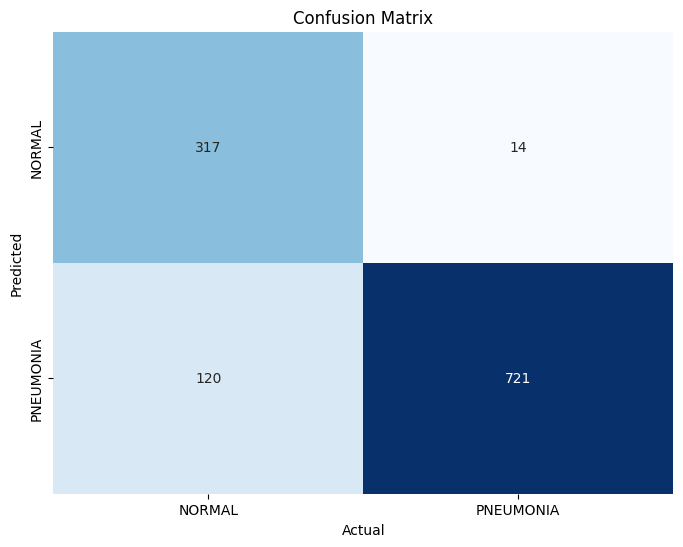

Classification Report : 
              precision    recall  f1-score   support

           0       0.73      0.96      0.83       331
           1       0.98      0.86      0.91       841

    accuracy                           0.89      1172
   macro avg       0.85      0.91      0.87      1172
weighted avg       0.91      0.89      0.89      1172



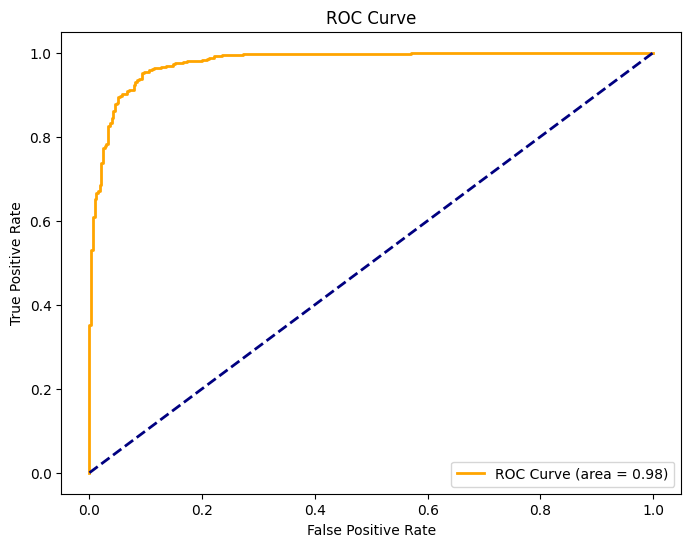

Accuracy: 0.8856655290102389
Precision: 0.9809523809523809
Recall: 0.8573127229488704
F1 Score: 0.91497461928934
ROC AUC Score: 0.9775084329905054


In [30]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = model.predict(X_test)
y_pred = np.round(y_pred_probs)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Rapport de classification
print("Classification Report : ")
print(classification_report(y_test, y_pred))

# Scores
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC Curve (area = {:.2f})'.format(roc_auc_score(y_test, y_pred_probs)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

## Model Deployment (Bonus)

### Objective

Learn the basics of deploying a machine learning model.

### Guidance

1. Save your trained model.
2. Use Flask to create a simple REST API to serve your model.

### Exercise

Deploy your model using Flask. Write your code in the cell below.


In [32]:
from tensorflow.keras.models import save_model
save_model(model, 'mon_modele.h5')

C:\Users\nscie\AppData\Local\Temp\ipykernel_8820\1546562860.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'mon_modele.h5')


In [35]:
from tensorflow.keras.models import load_model

# Chargement du modèle
model = load_model('mon_modele.h5')

# Architecture du modèle
model.summary()

# Hyperparamètres du modèle
model_config = model.get_config()
print(model_config)

# Poids du modèle
model_weights = model.get_weights()
print(model_weights)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 17, 17, 128)      

In [ ]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
import cv2
import numpy as np

app = Flask(__name__)

model = load_model('../Models/mon_modele.h5')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Image à partir de 'POST'
        image_file = request.files['image']
        # Lecture image 
        image = cv2.imdecode(np.frombuffer(image_file.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
        # Redimensionnement image 
        image = cv2.resize(image, (150, 150))
        # Normalisation pixels
        image = image / 255.0
        # Aplatissement image
        image = np.reshape(image, (1, 150, 150, 1))
        
        prediction = model.predict(image)
        if prediction > 0.5:
            result = 'PNEUMONIA'
        else:
            result = 'NORMAL'
        return jsonify({'prediction': result})
    
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(debug=True)


### Next Steps

1. Experiment with more advanced architectures and hyperparameters.
2. Deploy your model
3. Integrate your model into a web application or other services.
4. Learn more about MLOps best practices and tools.


